# Helping chemists design selective JAK inhibitors

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import copy
import rdkit
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import seaborn as sns
IPythonConsole.ipython_useSVG=True
from multiprocessing import Pool
from tqdm import tqdm

df = pd.read_csv('./kinase_JAK.csv')
df.head()

,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2


In [29]:
df.isna().sum()

SMILES               0
measurement_type     0
measurement_value    0
Kinase_name          0
dtype: int64

In [30]:
df.describe()

,measurement_value
count,10725.000000
mean,7.892468
std,1.169218
min,6.000000
25%,6.960000
50%,7.780000
75%,8.700000
max,12.240000


There are 10725 measurements in total.

SMILES is a text encoding of a molecular structure. You can read about it [here](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html), but you don't have to. 

measurement_type specifies how the measurement was being done. There are two types of measurements: pIC50 and pKi. For both measurements, a higher number means that the molecule binds stronger to the protein. 


measurement_value is the value of the measurement. 

Kinase_name is the name of the kinase that the molecule has been measured against. There are 4 different kinases in this dataset: JAK1, JAK2, JAK3, and TYR2. 

Our goal is to predict the pKi of a molecule against JAK1, JAK2, JAK3, and TYK2. 

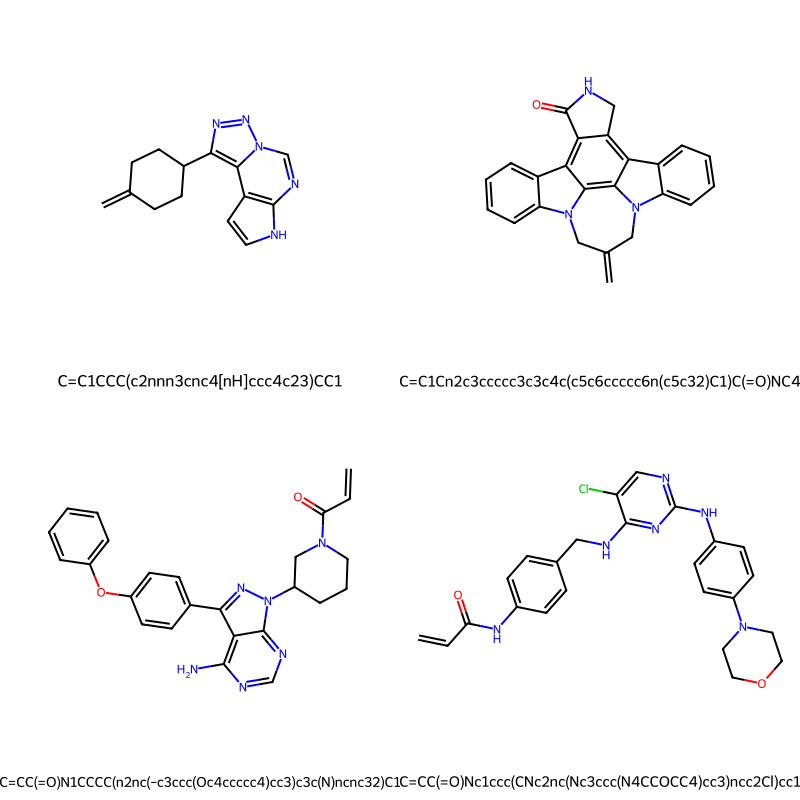

In [3]:
# generate a list of "smile" molecules
smiles = mol = df[df.Kinase_name=='JAK3']['SMILES'][:4]
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=2, useSVG=True,subImgSize=(400, 400), legends=list(smiles))

In [31]:

grouped_df=df.groupby('SMILES')

def filter_func(group):
      return group['measurement_value'].std()<0.1 and group['measurement_value'].count()>1

def filter_func1(group):
      return group['measurement_value'].std()>1 and group['measurement_value'].count()>1


def get_count(grouped_df,function):
    return len(np.unique(grouped_df.filter(function)['SMILES']))

print("these many compounds have similar pki/plc50 for different types of Kinase:",get_count(grouped_df,filter_func))

print("these many compounds have differnt pki/plc50 for different types of Kinase:",get_count(grouped_df,filter_func1))


these many compounds have similar pki/plc50 for different types of Kinase: 817
these many compounds have differnt pki/plc50 for different types of Kinase: 533


Looks like we have 817 compunds which have same inhibition value and therefore they cannot be used as a drug but its important to keep them in train set. This helps in elimination of compunds which cannot be used during inference as model learns pattern ffrom this data.

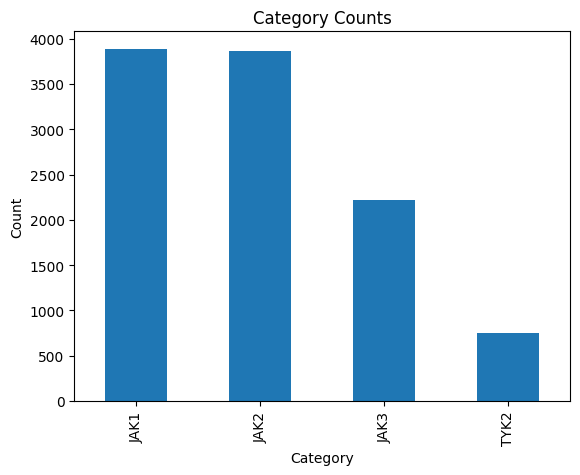

In [6]:
# Count the occurrences of each category
counts = df['Kinase_name'].value_counts()

# Plot the counts
counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

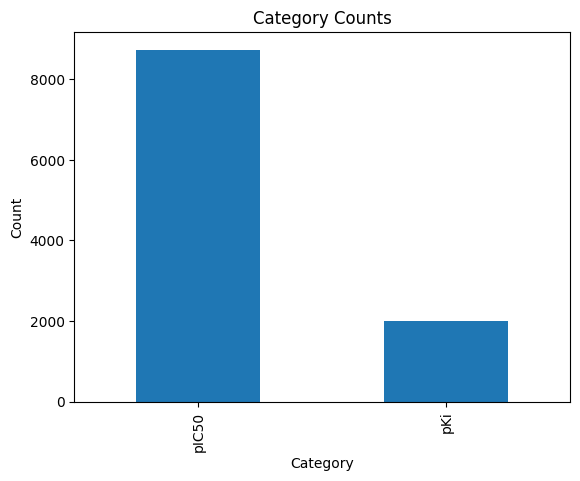

In [7]:
# Count the occurrences of each category
counts = df['measurement_type'].value_counts()

# Plot the counts
counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

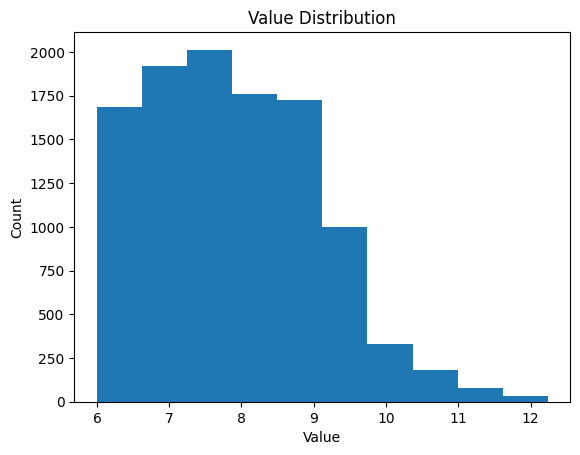

In [8]:
column = df['measurement_value']

# Plot the distribution of the column
plt.hist(column)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Value Distribution')
plt.show()

In [9]:
column_name = 'measurement_value'
mean = df[column_name].mean()
std = df[column_name].std()

# Identify outliers using the Z-score method
threshold = 3
z_scores = (df[column_name] - mean) / std
outliers = df[(z_scores > threshold) | (z_scores < -threshold)]

# Identify outliers using the Interquartile Range (IQR) method
q1, q3 = np.percentile(df[column_name], [25, 75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]


print(len(outliers.index),len(outliers.index)/len(df))

61 0.005687645687645688


Many of the data points that appear as outliers in the data are compounds that have high inhibition values. However, these should not be considered as outliers because they may have very low inhibition values with other kinase proteins. 

I decided to use min-max scaling and transformed the label
values (pKI/pIC50 values) into a range of 0 to 1. This was
done because the original values fell within a specific range
(6 to 12) and there were no significant outliers. Additionally,
values whose z-score was greater than 3 were considered
important molecules with high inhibition values and should
not be considered outliers. Furthermore, it is beneficial to scale
the values to be between 0 and 1 as the input features, such as
molecular fingerprints, are also on the same range. Therefore,
it is optimal to scale the inputs to match the range of the
outputs.

## bi variate analysis

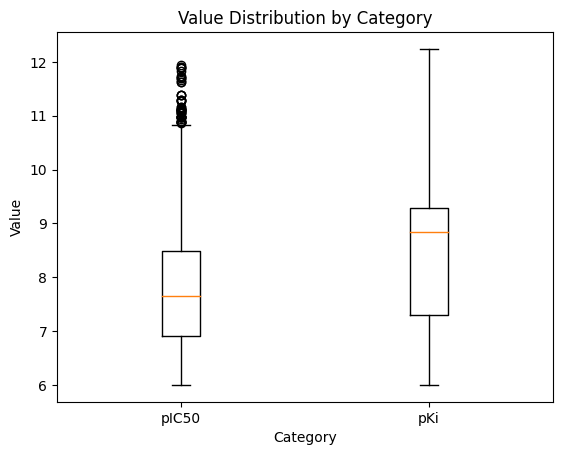

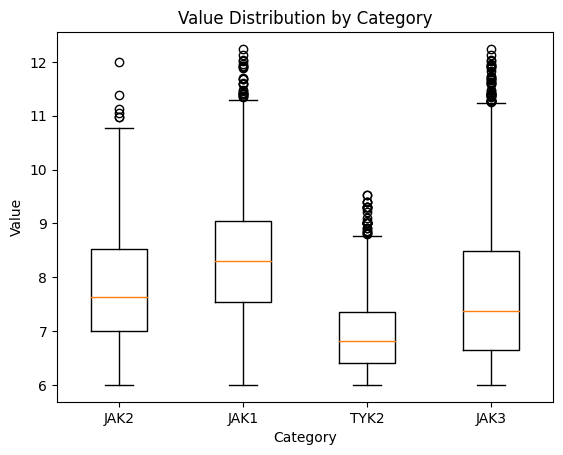

In [32]:
# Extract the columns of interest
numerical_column = df['measurement_value']
categorical_column = df['measurement_type']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Value Distribution by Category')

# Add the column values under the x-axis
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())

plt.show()

numerical_column = df['measurement_value']
categorical_column = df['Kinase_name']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Value Distribution by Category')

# Add the column values under the x-axis
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())

plt.show()

### target label distribution analysis with respect to kinase and measurement type

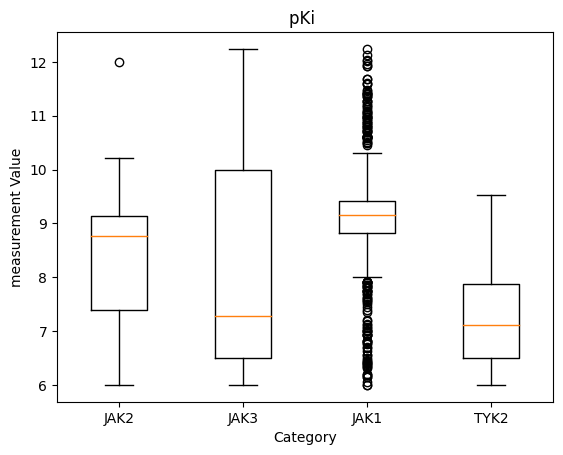

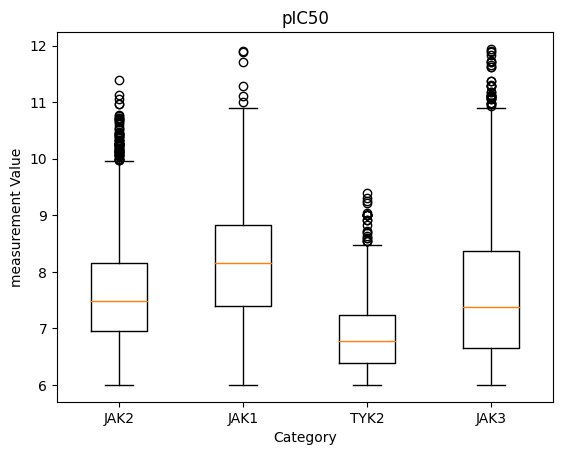

In [105]:

df1= df[df.measurement_type == 'pKi']
numerical_column = df1['measurement_value']
categorical_column = df1['Kinase_name']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('measurement Value')
plt.title('pKi ')
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())
plt.show()

df1= df[df.measurement_type != 'pKi']
numerical_column = df1['measurement_value']
categorical_column = df1['Kinase_name']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('measurement Value')
plt.title('pIC50')
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())
plt.show()

### plots showing number of chemical compunds that have high inhibition value compared to other kinases for pIc50 measurement type 

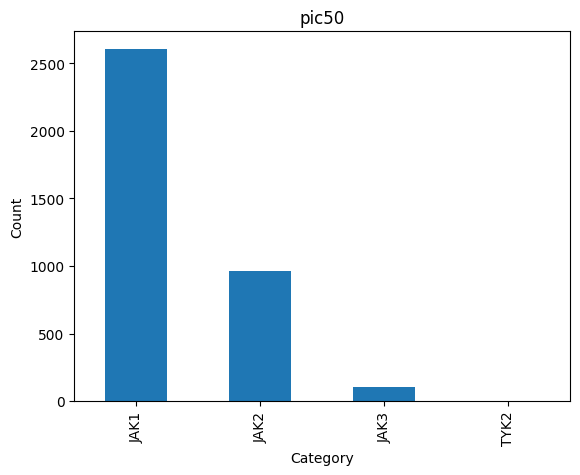

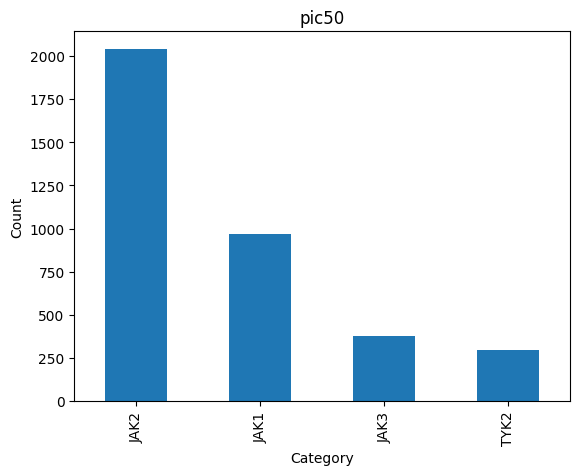

In [106]:
df1 = df[df.measurement_type !='pKi']

max_index = df1.loc[df1.groupby('SMILES')['measurement_value'].idxmax()]
max_kinase_name = max_index['Kinase_name']

max_kinase_name.value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('pic50')
plt.show()

max_index = df1.loc[df1.groupby('SMILES')['measurement_value'].idxmin()]
max_kinase_name = max_index['Kinase_name']

max_kinase_name.value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('pic50')
plt.show()




analysis based on measurement type:

pic50:

this test has more samples of compunds which has high inhibition to jak1 type of kinases, and less inhibiion capacity to jak2. 


### plots showing number of chemical compunds that have high inhibition value compared to other kinases for pKi measurement type 

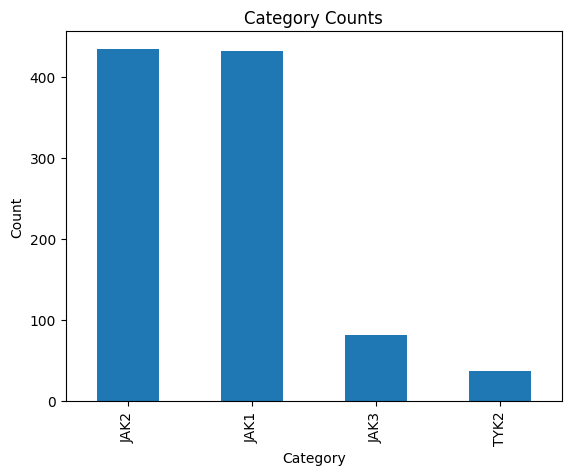

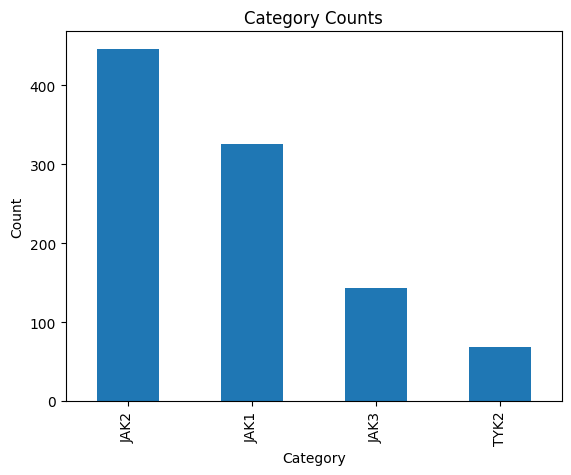

In [108]:
df1 = df[df.measurement_type =='pKi']

max_index = df1.loc[df1.groupby('SMILES')['measurement_value'].idxmax()]
max_kinase_name = max_index['Kinase_name']

max_kinase_name.value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

max_index = df1.loc[df1.groupby('SMILES')['measurement_value'].idxmin()]
max_kinase_name = max_index['Kinase_name']

max_kinase_name.value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()


analysis based on measurement type:

pki:

unlike pic50 this test has equal samples of compunds which has high inhibition to jak1, jak2 type of kinases.


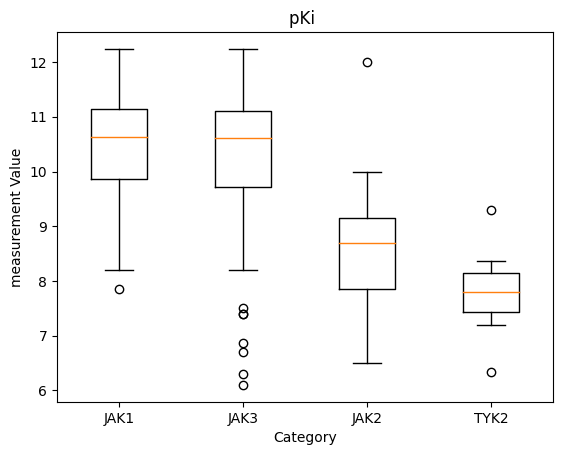

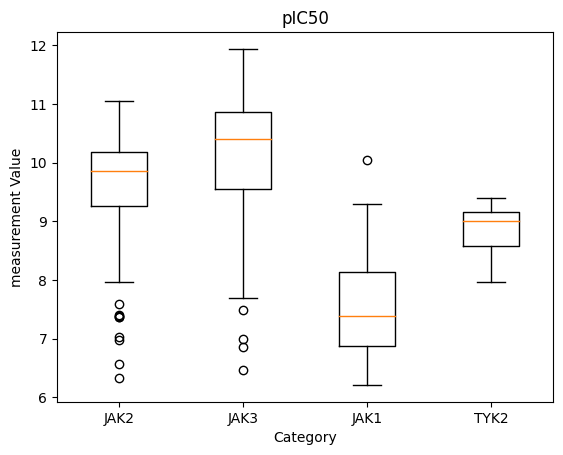

In [109]:
intersection = list(set(df[df.measurement_type =='pKi'].SMILES.values) & set(df[df.measurement_type !='pKi'].SMILES.values))
df_both = df[df['SMILES'].isin(intersection)]
max_value = df_both['SMILES'].value_counts().idxmax()

df_both1= df_both[df_both.measurement_type == 'pKi']
numerical_column = df_both1['measurement_value']
categorical_column = df_both1['Kinase_name']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('measurement Value')
plt.title('pKi ')
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())
plt.show()

df_both1= df_both[df_both.measurement_type != 'pKi']
numerical_column = df_both1['measurement_value']
categorical_column = df_both1['Kinase_name']

# Create a boxplot showing the distribution of the numerical column, grouped by the categories
plt.boxplot([numerical_column[categorical_column == c] for c in categorical_column.unique()])
plt.xlabel('Category')
plt.ylabel('measurement Value')
plt.title('pIC50')
plt.xticks(range(1, len(categorical_column.unique()) + 1), categorical_column.unique())
plt.show()